# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification


### Introduction

The project folder has the following structure:



* In the `src/` directory are several source files. 



> <img src="static_images/icons/noun-info-2558213.png" alt="?" style="width:25px"/> Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.



### Designing and training a CNN from scratch

In this notebook, you I have created a CNN that classifies landmarks. 

Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="static_images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

In Step 2 of this notebook, I have greatly improved accuracy by using transfer learning to create a CNN.

I experimented with different architectures, hyperparameters, training strategies, and trust your intuition.

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 0: Setting up


In [1]:
%%writefile requirements.txt
torch
torchvision


# Install requirements
!pip install -r requirements.txt | grep -v "already satisfied"

Overwriting requirements.txt


In [2]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), 'src'))

Important! After you have ran pip install, please restart the kernel using the **Kernel** menu 

In [1]:
!pip install tqdm
!pip install matplotlib

from src.helpers import setup_env

# If running locally, this will download dataset (make sure you have at 
# least 2 Gb of space on your hard drive)
setup_env()


GPU available
Dataset already downloaded. If you need to re-download, please delete the directory landmark_images
Reusing cached mean and std


---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 1: Data


Opened the file `src/data.py`. It contains a function called `get_data_loaders`. Completed the code.

In [5]:
!pytest -vv src/data.py -k data_loaders

============================= test session starts ==============================
platform linux -- Python 3.7.6, pytest-7.1.1, pluggy-1.2.0 -- /opt/conda/bin/python3.7
cachedir: .pytest_cache
rootdir: /workspace/home
collected 4 items / 1 deselected / 3 selected                                  

src/data.py::test_data_loaders_keys PASSED                               [ 33%]
src/data.py::test_data_loaders_output_type PASSED                        [ 66%]
src/data.py::test_data_loaders_output_shape PASSED                       [100%]

======================= 3 passed, 1 deselected in 5.87s ========================


Example of expected outcome:
```
src/data.py::test_data_loaders_keys PASSED                               [ 33%]
src/data.py::test_data_loaders_output_type PASSED                        [ 66%]
src/data.py::test_data_loaders_output_shape PASSED                       [100%]

======================= 3 passed, 1 deselected in 1.81s ========================
```
Once all the tests are `PASSED`, I moved to the next section.

> <img src="static_images/icons/noun-info-2558213.png" alt="?" style="width:25px"/> **What to do if tests fail**
When a test fails, `pytest` will mark it as `FAILED` as opposed to `PASSED`, and will print a lot of useful output, including a message that should tell you what the problem is. For example, this is the output of a failed test:
> ```
>    def test_data_loaders_keys(data_loaders):
>    
>       assert set(data_loaders.keys()) == {"train", "valid", "test"}
E       AssertionError: assert {'tes', 'train', 'valid'} == {'test', 'train', 'valid'}
E         Extra items in the left set:
E         'tes'
E         Full diff:
E         - {'test', 'train', 'valid'}
E         + {'tes', 'train', 'valid'}
E         ?                          +++++++
>
> src/data.py:171: AssertionError
-------------- Captured stdout setup ----------------------------------------------
Reusing cached mean and std for landmark_images
Dataset mean: tensor([0.4638, 0.4725, 0.4687]), std: tensor([0.2699, 0.2706, 0.3018])
=========== short test summary info ===============================================
FAILED src/data.py::test_data_loaders_keys - AssertionError: The keys of the data_loaders dictionary should be train, valid and test
> ``` 
> In the `short test summary info` you can see a short description of the problem. In this case, the dictionary we are returning has the wrong keys. Going above a little, you can see that the test expects `{'test', 'train', 'valid'}` while we are returning `{'tes', 'train', 'valid'}` (there is a missing `t`). So we can go back to our function, fix that problem and test again.
> 
> In other cases, you might get an error like:
> ```
    def _conv_forward(self, input: Tensor, weight: Tensor, bias: Optional[Tensor]):
        if self.padding_mode != 'zeros':
            return F.conv2d(F.pad(input, self._reversed_padding_repeated_twice, mode=self.padding_mode),
                            weight, bias, self.stride,
                            _pair(0), self.dilation, self.groups)
        return F.conv2d(input, weight, bias, self.stride,
>                       self.padding, self.dilation, self.groups)
E       RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
>
> ../../../../miniconda3/envs/udacity_starter/lib/python3.7/site-packages/torch/nn/modules/conv.py:440: RuntimeError
> ```
> Looking at the stack trace you should be able to understand what it is going on. In this case, we forgot to add a `.cuda()` to some tensor. For example, the model is on the GPU, but the data aren't.

<img src="static_images/icons/noun-question-mark-869751.png" alt="?" style="width:25px"/> **Question:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: 
I chose the procedure involving resizing images to 256 pixels (to ensure consistency across the dataset), then cropping them to 224x224 pixels (inspired by a popular pre-trained CNN architectures, such as VGG or ResNet). 

I did apply data augmentation to the training set through random horizontal flips and resized crops.
I used center-cropped augmentation for validation and test sets to maintain consistency. 

### Visualized a Batch of Training Data

Went back to `src/data.py` and completed the function `visualize_one_batch`.

In [11]:
!pytest -vv src/data.py -k visualize_one_batch

============================= test session starts ==============================
platform linux -- Python 3.7.6, pytest-7.1.1, pluggy-1.2.0 -- /opt/conda/bin/python3.7
cachedir: .pytest_cache
rootdir: /workspace/home
collected 4 items / 3 deselected / 1 selected                                  

src/data.py::test_visualize_one_batch PASSED                             [100%]

======================= 1 passed, 3 deselected in 5.35s ========================


Now I am using the code I have just completed to get a batch of images from my train data loader and look at them.

Visualizing the output of your data loader is a great way to ensure that my data loading and preprocessing (including transforms such as rotations, translations, color transforms...) are working as expected.

Reusing cached mean and std
Dataset mean: tensor([0.4638, 0.4725, 0.4687]), std: tensor([0.2699, 0.2706, 0.3018])
Reusing cached mean and std


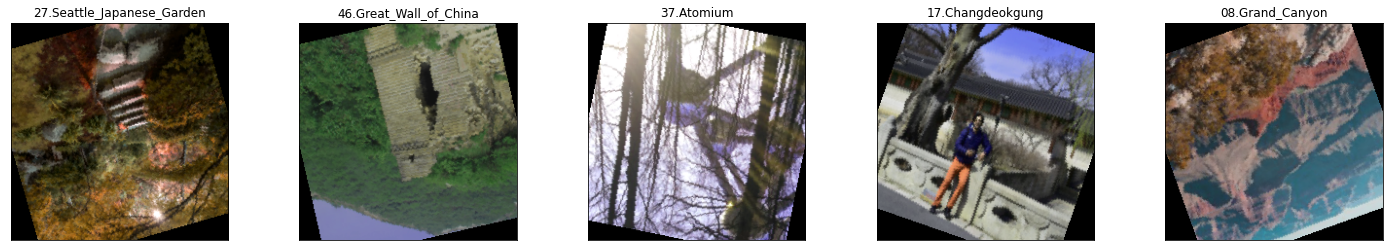

In [4]:
%matplotlib inline
from src.data import visualize_one_batch, get_data_loaders

# use get_data_loaders to get the data_loaders dictionary. Use a batch_size
# of 5, a validation size of 0.01 and num_workers=-1 (all CPUs)
data_loaders = get_data_loaders(batch_size=5, valid_size=0.01, num_workers=1)

visualize_one_batch(data_loaders)

In [16]:
import matplotlib.pyplot as plt

#Ensuring that your visualize_one_batch function is displaying images correctly
def visualize_one_batch(data_loaders):
    # Get a batch of training data
    inputs, classes = next(iter(data_loaders['train']))

    # Make a grid from batch
    out = torchvision.utils.make_grid(inputs)

    # Show images
    plt.figure(figsize=(15, 10))
    plt.imshow(out.numpy().transpose((1, 2, 0)))
    plt.title([str(x.item()) for x in classes])
    plt.show()


Reusing cached mean and std
Dataset mean: tensor([0.4638, 0.4725, 0.4687]), std: tensor([0.2699, 0.2706, 0.3018])
Reusing cached mean and std


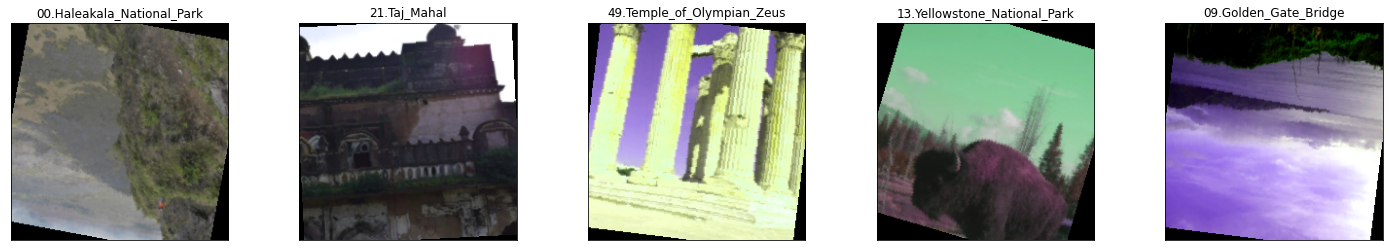

In [17]:
%matplotlib inline
from src.data import visualize_one_batch, get_data_loaders

# use get_data_loaders to get the data_loaders dictionary. Use a batch_size
# of 5, a validation size of 0.01 and num_workers=-1 (all CPUs)
data_loaders = get_data_loaders(batch_size=5, valid_size=0.01, num_workers=1)

visualize_one_batch(data_loaders)

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 2: Defining the model

Opened `src/model.py` and completed the `MyModel` class.

In [14]:
!pytest -vv src/model.py

============================= test session starts ==============================
platform linux -- Python 3.9.16, pytest-8.2.2, pluggy-1.5.0 -- /home/studio-lab-user/.conda/envs/default/bin/python3.9
cachedir: .pytest_cache
rootdir: /home/studio-lab-user/sagemaker-studiolab-notebooks/Project_3_ML_Engineer/unzipped_files
plugins: anyio-3.7.1
collected 1 item                                                               

src/model.py::test_model_construction PASSED                             [100%]

============================== 1 passed in 3.00s ===============================


<img src="static_images/icons/noun-question-mark-869751.png" alt="?" style="width:25px"/> **Question**: Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

<img src="static_images/icons/noun-answer-3361020.png" alt=">" style="width:25px"/> __Answer:__ 

Created a CNN architecture with convolutional layers for feature extraction,FC layers for classification, including layers: Conv2d, ReLU, MaxPool2d, Linear, and Dropout.

The data loaders for training, validation, and testing were set applying transformations such as resising, cropping, flipping, and normalisation. I also used subset random samplers to create data loaders from split datasets. 

Subsequently, I had to ensure that FC layer dimensions matched the output from the convolutional layers.

Followed by the implementation of MyModel class with appropriate layers and using a forward method, the instance of the model was created and validated after.

Tests to verify data loader keys were conducted to ensure the model could process data correctly and produce the expected shape of the output.

This approach described above ensured a robust, well-structured CNN model for image classification.

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 3: defining loss and optimizer

Opened `src/optimization.py` and completed the `get_loss` function, then executed the test and made sure it passed.

In [6]:
!pytest -vv src/optimization.py -k get_loss

============================= test session starts ==============================
platform linux -- Python 3.7.6, pytest-7.1.1, pluggy-1.2.0 -- /opt/conda/bin/python3.7
cachedir: .pytest_cache
rootdir: /workspace/home
collected 7 items / 6 deselected / 1 selected                                  

src/optimization.py::test_get_loss PASSED                                [100%]

======================= 1 passed, 6 deselected in 2.07s ========================


Then, in the same file, completed the `get_optimizer` function then executed its tests, and made sure they all passed.

In [7]:
!pytest -vv src/optimization.py -k get_optimizer

============================= test session starts ==============================
platform linux -- Python 3.7.6, pytest-7.1.1, pluggy-1.2.0 -- /opt/conda/bin/python3.7
cachedir: .pytest_cache
rootdir: /workspace/home
collected 7 items / 1 deselected / 6 selected                                  

src/optimization.py::test_get_optimizer_type PASSED                      [ 16%]
src/optimization.py::test_get_optimizer_is_linked_with_model PASSED      [ 33%]
src/optimization.py::test_get_optimizer_returns_adam PASSED              [ 50%]
src/optimization.py::test_get_optimizer_sets_learning_rate PASSED        [ 66%]
src/optimization.py::test_get_optimizer_sets_momentum PASSED             [ 83%]
src/optimization.py::test_get_optimizer_sets_weight_decat PASSED         [100%]

======================= 6 passed, 1 deselected in 1.94s ========================


---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 4: Training and Validating the Model

> <img src="static_images/icons/noun-info-2558213.png" alt="?" style="width:25px"/> Testing ML code is notoriously difficult. The tests in this section merely exercise the functions I am completing.

Opened `src/train.py` and completed the `train_one_epoch` function, then run the tests.

In [8]:
!pytest -vv src/train.py -k train_one_epoch

============================= test session starts ==============================
platform linux -- Python 3.7.6, pytest-7.1.1, pluggy-1.2.0 -- /opt/conda/bin/python3.7
cachedir: .pytest_cache
rootdir: /workspace/home
collected 4 items / 3 deselected / 1 selected                                  

src/train.py::test_train_one_epoch PASSED                                [100%]

================== 1 passed, 3 deselected in 84.13s (0:01:24) ==================


Now complete the `valid` function, then run the tests:

In [9]:
!pytest -vv src/train.py -k valid_one_epoch

============================= test session starts ==============================
platform linux -- Python 3.7.6, pytest-7.1.1, pluggy-1.2.0 -- /opt/conda/bin/python3.7
cachedir: .pytest_cache
rootdir: /workspace/home
collected 4 items / 3 deselected / 1 selected                                  

src/train.py::test_valid_one_epoch PASSED                                [100%]

================== 1 passed, 3 deselected in 79.27s (0:01:19) ==================


In [10]:
import torch

torch.cuda.empty_cache()#To clear the cache in order for my next cell to run smoothly

Now complete the `optimize` function, then run the tests:

In [11]:
!pytest -vv src/train.py -k optimize

============================= test session starts ==============================
platform linux -- Python 3.7.6, pytest-7.1.1, pluggy-1.2.0 -- /opt/conda/bin/python3.7
cachedir: .pytest_cache
rootdir: /workspace/home
collected 4 items / 3 deselected / 1 selected                                  

src/train.py::test_optimize Killed


Finally, complete the `test` function then run the tests:

In [12]:
!pytest -vv src/train.py -k one_epoch_test

============================= test session starts ==============================
platform linux -- Python 3.7.6, pytest-7.1.1, pluggy-1.2.0 -- /opt/conda/bin/python3.7
cachedir: .pytest_cache
rootdir: /workspace/home
collected 4 items / 3 deselected / 1 selected                                  

src/train.py::test_one_epoch_test PASSED                                 [100%]

================== 1 passed, 3 deselected in 87.79s (0:01:27) ==================


---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 5: Putting everything together

In the following cell I trained my model and validated it against the validation set.

I started by defining a few hyperparameters. Experimented with different values trying to optimize your model

In [2]:
batch_size = 128
valid_size = 0.2
num_epochs = 100
num_classes = 50
dropout = 0.5
learning_rate = 0.0005
opt = 'adam'
weight_decay = 0.0004


In [3]:
import torch
torch.cuda.empty_cache()

In [15]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [3]:
from src.data import get_data_loaders
from src.train import optimize
from src.optimization import get_optimizer,get_loss
from src.model import MyModel


In [4]:
data_loaders = get_data_loaders(batch_size = batch_size ,valid_size = valid_size )
model = MyModel(num_classes, dropout)
optimizer = get_optimizer(model, opt, learning_rate,
                          weight_decay)
loss = get_loss()

Reusing cached mean and std
Dataset mean: tensor([0.4638, 0.4725, 0.4687]), std: tensor([0.2699, 0.2706, 0.3018])


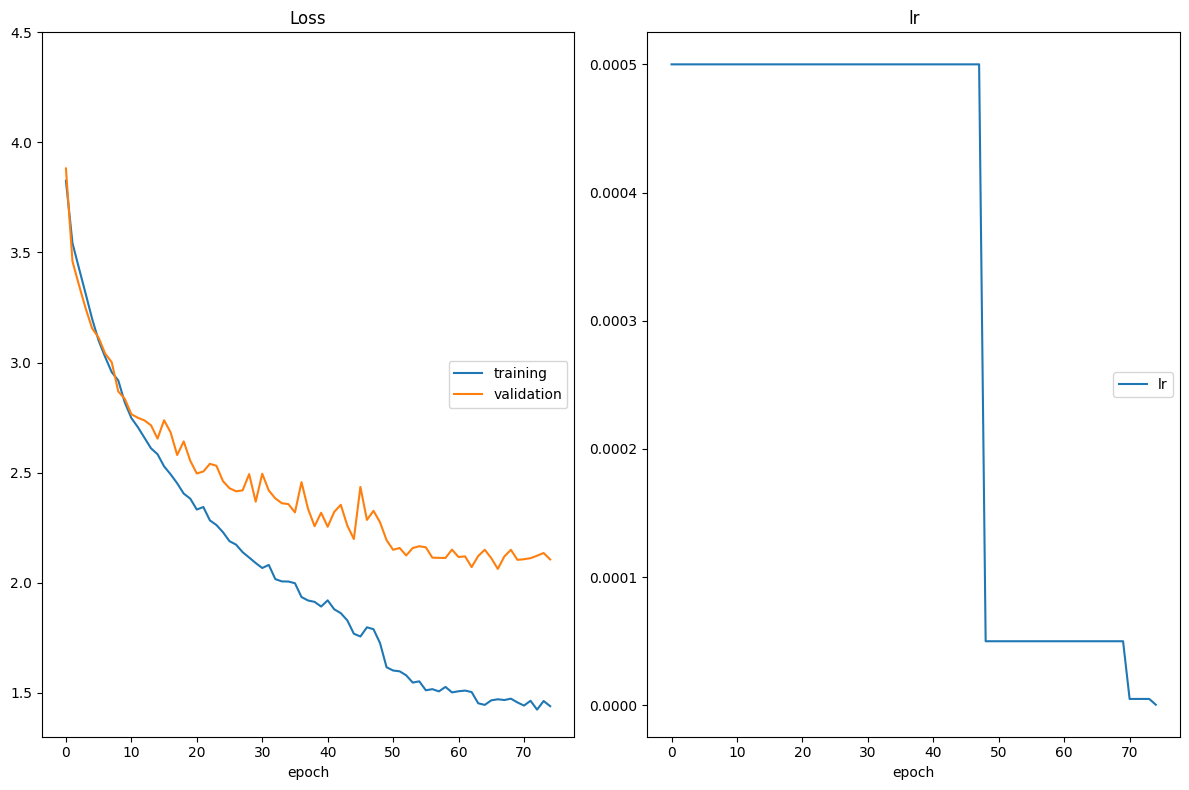

Epoch 76/100 starting...


Training:  19%|██████▍                           | 6/32 [00:04<00:17,  1.49it/s]


KeyboardInterrupt: 

In [5]:
optimize(
    data_loaders,
    model,
    optimizer,
    loss,
    n_epochs = num_epochs,
    save_path = "checkpoints/best_val_loss.pt",
    interactive_tracking = True)


---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 6: testing against the Test Set

> <img src="static_images/icons/noun-info-2558213.png" alt="?" style="width:25px"/> o

Run the code cell below trying out my model on the test dataset of landmark images. Ensuring that your test accuracy is greater than 50%.

In [6]:
# load the model that got the best validation accuracy
from src.train import one_epoch_test
from src.model import MyModel
import torch

model = MyModel(num_classes=num_classes, dropout=dropout)

# YOUR CODE HERE: load the weights in 'checkpoints/best_val_loss.pt'
model.load_state_dict(torch.load('checkpoints/best_val_loss.pt'))

# Run test
one_epoch_test(data_loaders['test'], model, loss)

Testing: 100%|██████████████████████████████████| 10/10 [00:07<00:00,  1.37it/s]

Test Loss: 1.835420


Test Accuracy: 52.40% (655.0/1250.0)


1.8354198813438416

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 7: Exporting using torchscript

Now that I have put in all the work of creating accurate classifiers, I exported it so I could use it in my app.


Opened `src/predictor.py` and filled up the missing code, then run the tests.

In [7]:
!pytest -vv src/predictor.py

============================= test session starts ==============================
platform linux -- Python 3.9.16, pytest-8.2.2, pluggy-1.5.0 -- /home/studio-lab-user/.conda/envs/default/bin/python3.9
cachedir: .pytest_cache
rootdir: /home/studio-lab-user/sagemaker-studiolab-notebooks/Project_3_ML_Engineer/unzipped_files
plugins: anyio-3.7.1
collected 1 item                                                               

src/predictor.py::test_model_construction PASSED                         [100%]

============================== 1 passed in 3.06s ===============================


To export my model using my Predictor class.

In [9]:
# NOTE: you might need to restart the notebook before running this step
# If you get an error about RuntimeError: Can't redefine method: forward on class
# restart your notebook then execute only this cell
from src.predictor import Predictor
from src.helpers import compute_mean_and_std
from src.model import MyModel
from src.data import get_data_loaders
import torch
import os

data_loaders = get_data_loaders(batch_size=1)

# First let's get the class names from our data loaders
class_names = data_loaders["train"].dataset.classes

# Then let's move the model_transfer to the CPU
# (we don't need GPU for inference)
model = MyModel(num_classes=50, dropout=0.5).cpu()

# Let's make sure we use the right weights by loading the
# best weights we have found during training
# NOTE: remember to use map_location='cpu' so the weights
# are loaded on the CPU (and not the GPU)

# Load the model weights
checkpoint_path = "checkpoints/best_val_loss.pt"
if os.path.exists(checkpoint_path):
    try:
        checkpoint = torch.load(checkpoint_path, map_location='cpu')
        model.load_state_dict(checkpoint)
        print("Model weights loaded successfully.")
    except Exception as e:
        print("Error loading model weights:", e)
else:
    print("Checkpoint file not found at:", checkpoint_path)

# Let's wrap our model using the predictor class
mean, std = compute_mean_and_std()
predictor = Predictor(model, class_names, mean, std).cpu()

# Export using torch.jit.script
scripted_predictor = torch.jit.script(predictor)

scripted_predictor.save("checkpoints/original_exported.pt")


Reusing cached mean and std
Dataset mean: tensor([0.4638, 0.4725, 0.4687]), std: tensor([0.2699, 0.2706, 0.3018])
Model weights loaded successfully.
Reusing cached mean and std


In [10]:
import torch

# Load using torch.jit.load
model_reloaded = torch.jit.load('checkpoints/original_exported.pt')  # YOUR CODE HERE

Making sure the exported model has the same performance as the original one, by reloading it and testing it. The Predictor class takes different inputs than the non-wrapped model, so I had to use a specific test loop:

In [11]:
import torch

# Load using torch.jit.load
model_reloaded = torch.jit.load("checkpoints/original_exported.pt")

# Verify that the model was loaded correctly
print(model_reloaded)

RecursiveScriptModule(
  original_name=Predictor
  (model): RecursiveScriptModule(
    original_name=MyModel
    (backbone): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(original_name=Conv2d)
      (1): RecursiveScriptModule(original_name=BatchNorm2d)
      (2): RecursiveScriptModule(original_name=ReLU)
      (3): RecursiveScriptModule(original_name=MaxPool2d)
      (4): RecursiveScriptModule(original_name=Conv2d)
      (5): RecursiveScriptModule(original_name=BatchNorm2d)
      (6): RecursiveScriptModule(original_name=ReLU)
      (7): RecursiveScriptModule(original_name=MaxPool2d)
      (8): RecursiveScriptModule(original_name=Conv2d)
      (9): RecursiveScriptModule(original_name=BatchNorm2d)
      (10): RecursiveScriptModule(original_name=ReLU)
      (11): RecursiveScriptModule(original_name=MaxPool2d)
      (12): RecursiveScriptModule(original_name=Conv2d)
      (13): RecursiveScriptModule(original_name=BatchNorm2d)
      (14): RecursiveScr

In [12]:
from src.predictor import predictor_test

pred, truth = predictor_test(data_loaders['test'], model_reloaded)

100%|███████████████████████████████████████| 1250/1250 [00:18<00:00, 66.98it/s]

Accuracy: 0.5232


Having a look at the confusion matrix of the model I am going to use in production:

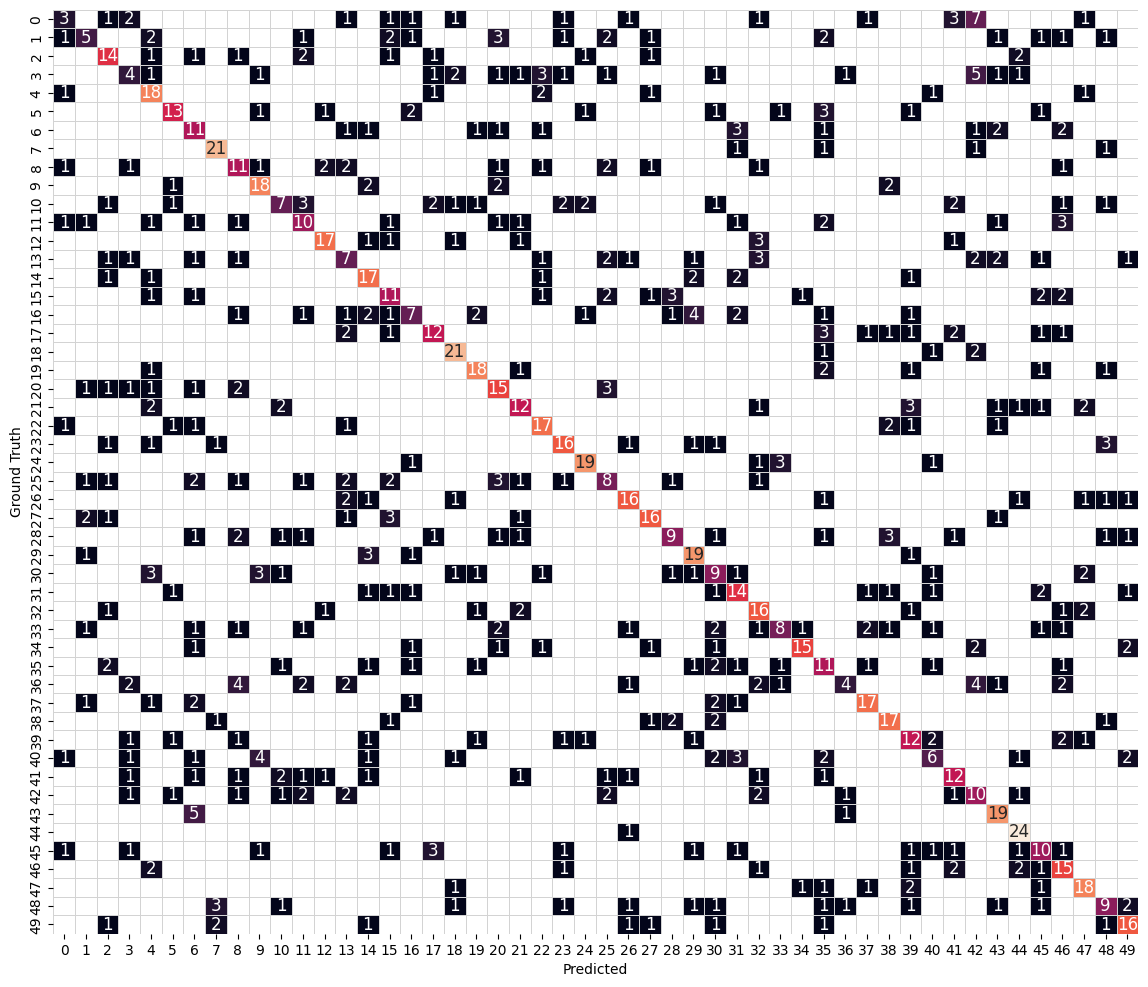

In [13]:
!pip install seaborn

from src.helpers import plot_confusion_matrix

plot_confusion_matrix(pred, truth)